<a href="https://colab.research.google.com/github/sdeshmukh99/Generative-AI-Showcase/blob/main/Showcase_03/Transformer_Encoder_for_Sentiment_Classification_with_IMDB_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1: Importing packages

In [60]:
# Install the required packages: Hugging Face Transformers and Datasets.
!pip install transformers datasets


In [61]:
# Core mathematical functions, including logarithms and square roots
import math

# PyTorch libraries to build neural networks and layers
import torch
import torch.nn as nn
import torch.nn.functional as F

# Utilities for handling datasets in PyTorch
from torch.utils.data import Dataset

# Numpy for handling array-like data
import numpy as np

# Matplotlib for plotting graphs and visualizing data
import matplotlib.pyplot as plt

# Hugging Face libraries for handling pretrained tokenizers and datasets
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset

# PyTorch's DataLoader, which helps to load data in batches
from torch.utils.data import DataLoader

# For getting current time, useful in measuring performance and duration
from datetime import datetime

# Pretty-printing to make the outputs more readable
from pprint import pprint

# PCA (Principal Component Analysis) for dimensionality reduction
from sklearn.decomposition import PCA

# StandardScaler for scaling input data before applying PCA
from sklearn.preprocessing import StandardScaler

# Pandas for data manipulation, particularly with DataFrames
import pandas as pd

# WordCloud for creating word cloud visualizations of text data
from wordcloud import WordCloud



# 2: Loading IMdB Dataset

In [62]:
# Load the IMDB dataset
imdb_dataset = load_dataset("imdb")

# Check the dataset structure
print(imdb_dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [63]:
from IPython import get_ipython

# Get the IPython environment to run setup commands
ipython = get_ipython()

# Setup function to download IMDB sentiment analysis data for later use
def setup():
    ipython.magic("sx curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz")
    ipython.magic("sx tar -xvzf aclImdb_v1.tar.gz")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return


# 3: Encoder Transformer
This section describes how to build an encoder for a transformer. The encoder is a part of the transformer model that processes input data and creates meaningful internal representations of the data.

# 3A: Designing the Encoder

### 3A1: Defining Multi Head Attention
Multi-head attention allows the model to look at different parts of the input sequence simultaneously. This helps the model understand the relationships between different words or tokens in the input.

Explanation:
- Multi-head attention: It allows the model to focus on different parts of the input simultaneously, by splitting the input into n_heads and processing them in parallel.
- Query, Key, and Value: The input is transformed into query, key, and value matrices, which are then used to calculate the attention.
- Attention score calculation: It is done by taking a dot product between query and key matrices, scaling it by the square root of d_k (to stabilize training), and applying softmax.
- Masking: If a mask is provided, it prevents attention on certain tokens (like padding tokens) by setting their attention scores to -inf so they don't affect the output.

In [64]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_k, d_model, n_heads):
        super().__init__()
        # Number of heads and key dimension
        self.d_k = d_k
        self.n_heads = n_heads

        # Linear layers to project input into key, query, and value spaces
        self.key = nn.Linear(d_model, d_k * n_heads)
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)

        # Final linear layer to combine heads
        self.fc = nn.Linear(d_k * n_heads, d_model)

    def forward(self, q, k, v, mask=None):
        # Compute query, key, and value projections
        q = self.query(q)  # Shape: (batch_size, seq_len, h * d_k)
        k = self.key(k)
        v = self.value(v)

        N = q.shape[0]  # Batch size
        T = q.shape[1]  # Sequence length

        # Reshape into (batch_size, n_heads, seq_len, d_k) for multi-head attention
        q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

        # Calculate attention scores using scaled dot-product
        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)  # Shape: (batch_size, n_heads, seq_len, seq_len)

        # Apply mask if provided, masking certain positions with -infinity
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)  # Adjust mask shape for broadcasting
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        # Compute attention weights (softmax of attention scores)
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Multiply attention weights by values to get attention output
        A = attn_weights @ v  # Shape: (batch_size, n_heads, seq_len, d_k)

        # Reshape back to (batch_size, seq_len, h * d_k) before final linear layer
        A = A.transpose(1, 2).contiguous().view(N, T, self.d_k * self.n_heads)

        # Apply final linear layer to combine multi-heads
        return self.fc(A)



### 3A2: Designing Transformer Block
Each transformer block consists of multi-head attention, followed by a feed-forward neural network (FFN), and layer normalization.

Explanation:
- Layer Normalization (ln1, ln2): Stabilizes training by normalizing the output of each layer.
- Multi-head Attention (mha): The core component that lets the model attend to different parts of the input sequence.
- Feed-forward Neural Network (ann): A fully connected network applied after attention, with two linear layers and GELU activation. It increases the dimensionality by 4 times and then reduces it back to the original size.
- Dropout: Regularization technique to prevent overfitting by randomly dropping certain connections during training.
- Residual Connections: Adds the original input back after multi-head attention and feed-forward layers to maintain gradient flow and avoid vanishing gradients.

This block is a fundamental unit in transformers that combines attention with a feed-forward network and normalization.

In [65]:
class TransformerBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, dropout_prob=0.1):
        super().__init__()

        # Layer normalization helps to stabilize and accelerate training
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        # Multi-head attention mechanism
        self.mha = MultiHeadAttention(d_k, d_model, n_heads)

        # Feed-forward network with GELU activation (applied after attention)
        self.ann = nn.Sequential(
            nn.Linear(d_model, d_model * 4),  # Expands dimensionality
            nn.GELU(),  # Activation function
            nn.Linear(d_model * 4, d_model),  # Projects back to original dimension
            nn.Dropout(dropout_prob),  # Applies dropout for regularization
        )

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, mask=None):
        # Step 1: Apply multi-head attention followed by layer normalization
        x = self.ln1(x + self.mha(x, x, x, mask))

        # Step 2: Apply feed-forward network (FFN) followed by layer normalization
        x = self.ln2(x + self.ann(x))

        # Step 3: Apply dropout to the output
        x = self.dropout(x)

        return x


### 3A3: Designing Positional Embedding
Positional encoding helps the model understand the order of tokens in the sequence since transformers do not inherently understand position.





In [66]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len =2048, dropout_prob=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p = dropout_prob)

    position = torch.arange(max_len).unsqueeze(1)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term*(-math.log(10000.0)/d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position *div_term)
    pe[0, :, 1::2] = torch.cos(position *div_term)
    self.register_buffer('pe', pe)


  def forward(self, x):
    # x.shape : N x T x D
    x=x + self.pe[:, :x.size(1), :]
    return self.dropout(x)


### 3A4: Creating Encoder Class
This class combines embeddings, positional encoding, and multiple transformer blocks.

Explanation:
- Dropout Layer: Helps to prevent overfitting by randomly zeroing some of the elements in the input tensor during training.
- Positional Encoding Calculation:
  - It generates a fixed positional encoding matrix using sine and cosine functions.
  - The encoding uses different frequencies for different dimensions.
  - Odd dimensions are assigned cosine values, while even dimensions get sine values.
- Register Buffer: self.register_buffer('pe', pe) stores the positional encoding (pe) as a buffer in the model. This means it won’t be updated during training (it's not a learnable parameter) but is still part of the model.
- Adding Positional Encoding: In the forward() method, the positional encodings are added to the input tensor x before applying dropout.

This helps the transformer model understand the order of tokens in a sequence, as transformers don't have any inherent notion of sequence order.



In [67]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048, dropout_prob=0.1):
        super().__init__()

        # Dropout for regularization
        self.dropout = nn.Dropout(p=dropout_prob)

        # Create position indices for max_len
        position = torch.arange(max_len).unsqueeze(1)

        # Compute sinusoidal frequencies using exponential decay for even and odd dimensions
        exp_term = torch.arange(0, d_model, 2)
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))

        # Initialize positional encoding matrix
        pe = torch.zeros(1, max_len, d_model)

        # Apply sine to even indices and cosine to odd indices
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        # Register the positional encoding as a non-learnable buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to input tensor
        # x.shape: (batch_size, sequence_length, embedding_dim)
        x = x + self.pe[:, :x.size(1), :]

        # Apply dropout for regularization
        return self.dropout(x)



### 3A5: Testing the Forward Pass with Dummy Values

- Model Initialization: We set up the model's hyperparameters like vocabulary size, model dimension, number of attention heads, and dropout probability, and create an instance of the Encoder class.

- Device Setup: We check if CUDA (GPU) is available and set the device accordingly. The model is moved to this device for faster computation if possible.

- Data Preparation: Random input sequences of token IDs are generated to simulate tokenized text input. A dynamic mask is created to mask certain parts of the sequence (useful in transformer models).

- Forward Pass: The model processes the input and mask, producing the output cls_token_output (a compressed representation) and y (the logits for each class). Finally, we check the shape of the logits to ensure everything is correct.

In [68]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, max_len, d_k, d_model, n_heads, n_layers, n_classes, dropout_prob=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout_prob)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(d_k, d_model, n_heads, dropout_prob) for _ in range(n_layers)]
        )
        self.fc_out = nn.Linear(d_model, n_classes)
        self.max_len = max_len

    def forward(self, x, mask=None):
        # x: (batch_size, seq_length)
        x = self.embedding(x)  # (batch_size, seq_length, d_model)
        x = self.pos_encoding(x)
        for transformer in self.transformer_blocks:
            x = transformer(x, mask)
        # Use the output corresponding to the [CLS] token (assumed to be the first token)
        cls_token_output = x[:, 0, :]  # (batch_size, d_model)
        logits = self.fc_out(cls_token_output)  # (batch_size, n_classes)
        return cls_token_output, logits


# Set model hyperparameters
vocab_size = 20000  # Size of the vocabulary (number of unique tokens)
max_length = 1024  # Maximum sequence length
d_k = 16  # Dimension for each attention head
d_model = 64  # Dimension of the model (embedding size)
n_heads = 4  # Number of attention heads
nlayers = 2  # Number of transformer layers (blocks)
n_classes = 5  # Number of output classes
dropout_prob = 0.1  # Dropout probability

# Initialize the custom Encoder model with the above hyperparameters
model = Encoder(vocab_size, max_length, d_k, d_model, n_heads, nlayers, n_classes, dropout_prob)

# Check if a GPU (CUDA) is available, otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Display the device being used (GPU/CPU)

# Move the model to the chosen device
model.to(device)

# Dynamic batch size and sequence length for input data
batch_size = 8  # Number of sequences (adjustable)
seq_length = 512  # Length of each sequence (can be adjusted)

# Generate random input data (token IDs), simulating tokenized text sequences
x = np.random.randint(0, vocab_size, size=(batch_size, seq_length))
x_t = torch.tensor(x).to(device)  # Convert to a PyTorch tensor and move to the device

# Create a binary mask (1s and 0s) for attention, dynamically based on batch size and sequence length
mask = np.ones((batch_size, seq_length))  # All ones initially
mask[:, seq_length//2:] = 0  # Mask the second half of each sequence (optional example)
mask_t = torch.tensor(mask, dtype=torch.bool).to(device)  # Convert to boolean tensor and move to device

# Perform a forward pass through the model with the input data and mask
cls_token_output, y = model(x_t, mask_t)

# Check the shape of the output (logits)
y.shape  # Expected output: (batch_size, n_classes), e.g., (8, 5)


cuda:0


torch.Size([8, 5])

# 3B. Train the Encoder

- We are going to use model built above (custom  encoder architecture) for sentiment classificaiton.

- This section demonstrates how to train a custom transformer encoder for sentiment classification using the Huggingface library. The GLUE SST-2 dataset is used to train the model, and this involves loading the dataset, tokenizing it, creating the model, and running a training loop.

## 3B1: Load the Data
It loads the SST-2 dataset, which is a part of the GLUE benchmark for sentiment analysis (positive/negative).
... a binary sentiment classification dataset (positive/negative).

In [69]:
# sst2 is DataSet for sentiment analysis as a part of glue bench-mark
raw_datasets = load_dataset("glue", "sst2")

## 3B2: Understand the Data:
Exploring the structure and content of the dataset. This step prints information about the dataset, including its features and a few example sentences to understand what the model will be trained on.

- dir(raw_datasets['train']): Lists all the attributes and methods available for the training dataset, which can help understand how to manipulate or interact with it.
- type(raw_datasets['train']): Identifies the dataset type (usually a Huggingface dataset class), helping to know what kind of object you're working with.
- raw_datasets['train'].data: This shows the raw underlying data, which can be useful if you need to inspect how the dataset is stored or structured internally.
- Example Samples: By inspecting the content of specific indices (e.g., raw_datasets['train'][1]), you can understand the nature of the data you're working with (e.g., text sentences and their corresponding labels).

In [70]:
# Print the entire dataset to inspect its structure
raw_datasets

# Features of the training data
raw_datasets['train'].features

# Training dataset overview
raw_datasets['train']

# Inspect methods and attributes available for the training dataset
dir(raw_datasets['train'])

# Check the type of the training dataset object
type(raw_datasets['train'])

# View the raw data of the training dataset
raw_datasets['train'].data

# Inspect specific samples
raw_datasets['train'][1]  # View a specific entry
raw_datasets['train'][10:14]  # View multiple entries
raw_datasets['train'][0:3]['sentence']  # View first 3 sentences


['hide new secretions from the parental units ',
 'contains no wit , only labored gags ',
 'that loves its characters and communicates something rather beautiful about human nature ']

## 3B3: Tokenize the Data
- The tokenizer converts the input text into a format that the model can process (i.e., tokens). It generates token indices and attention masks.
- Data Collator adds padding to the batches to ensure that all sequences in a batch have the same length.


In [71]:
# Load a pre-trained tokenizer for distilBERT
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize a sample sentence for demonstration
tokenized_sentences = tokenizer('hide new secretions from the parental units')
pprint(tokenized_sentences)

# Function to tokenize the entire dataset
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

# Tokenize the full dataset
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)

# Data collator handles padding of sentences to ensure equal lengths in batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

data_collator

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101, 4750, 1207, 3318, 5266, 1121, 1103, 22467, 2338, 102]}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/872 [00:00<?, ? examples/s]

DataCollatorWithPadding(tokenizer=DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}, padding=True, max_length=None, pad_to_multiple_of=None, return_tensors='pt')

## 3B4: Prepare the Dataloaders:
Prepare the data for training using PyTorch’s DataLoader to efficiently load the dataset in batches. DataLoader loads the dataset in batches, shuffling the training data for randomness.

In [72]:
tokenized_datasets

# Remove unnecessary columns and rename label for training
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Create data loaders for training and validation
train_loader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=32, collate_fn=data_collator)
valid_loader = DataLoader(tokenized_datasets["validation"], batch_size=32, collate_fn=data_collator)


## 3B5: Checking Tokenized Data and Model Configurations:

Verify that tokenization and data loading are working correctly, and it also checks the number of classes and the model's configuration.

In [73]:
# Check how the data looks in batches from the DataLoader
for batch in train_loader:
  for k, v in batch.items():
    print("k:", k, "v.shape:", v.shape)  # Print the shape of each batch element (input_ids, attention_mask, labels)
  break  # Stop after the first batch

# Get the unique classes (labels) in the dataset
set(tokenized_datasets['train']['labels'])

# Check the tokenizer vocabulary size
tokenizer.vocab_size

# Maximum sequence length for the model
tokenizer.model_max_length


k: labels v.shape: torch.Size([32])
k: input_ids v.shape: torch.Size([32, 35])
k: attention_mask v.shape: torch.Size([32, 35])


512

## 3B6: Create the Model
This defines the transformer encoder model with a specific configuration for sentiment classification.

Explanation:

- Model Configuration: Defines the transformer encoder model architecture with the required number of layers, heads, and classes.
- Loss Function: CrossEntropyLoss for binary classification.
- Optimizer: Adam to optimize model parameters.

In [74]:
# Instantiate the custom encoder model with configuration for classification
model = Encoder(
    vocab_size=tokenizer.vocab_size,
    max_len=tokenizer.model_max_length,
    d_k=16,
    d_model=64,
    n_heads=4,
    n_layers=2,
    n_classes=2,
    dropout_prob=0.1
)
model.to(device)

# Loss and optimizer for training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


## 3B7: Training Function
The train function runs through multiple epochs (full passes over the data) and optimizes the model using backpropagation. The function encapsulates the training process, iterating through the data, calculating the loss, and updating the model weights.

- Training Loop: Iterates over each batch of the dataset, performs forward and backward passes, calculates loss, and updates the weights.
- Epoch: A complete pass over the dataset.
- Validation: After each epoch, the model is evaluated on the validation set.

In [75]:
# Define a function to train the model over multiple epochs
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = 0
    n_train = 0

    for batch in train_loader:
      # Move data to GPU if available
      batch = {k: v.to(device) for k, v in batch.items()}

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass: calculate predictions
      cls_token_output, outputs = model(batch['input_ids'], batch['attention_mask'])

      # Calculate loss
      loss = criterion(outputs, batch['labels'])

      # Backward pass and optimize
      loss.backward()

      # Add gradient clipping
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()

      train_loss += loss.item() * batch['input_ids'].size(0)
      n_train += batch['input_ids'].size(0)

    # Compute average training loss
    train_loss = train_loss / n_train

    # Evaluate on validation set
    model.eval()
    test_loss = 0
    n_test = 0
    for batch in valid_loader:
      batch = {k: v.to(device) for k, v in batch.items()}
      cls_token_output, outputs = model(batch['input_ids'], batch['attention_mask'])
      loss = criterion(outputs, batch['labels'])
      test_loss += loss.item() * batch['input_ids'].size(0)
      n_test += batch['input_ids'].size(0)
    test_loss = test_loss / n_test

    # Save training and validation losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    # Print epoch summary
    dt = datetime.now() - t0
    print(f'Epoch {it + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

# Train the model for 4 epochs
train_losses, test_losses = train(model, criterion, optimizer, train_loader, valid_loader, epochs=4)


Epoch 1/4, Train Loss: 0.5375, Test Loss: 0.5304, Duration: 0:00:37.262208
Epoch 2/4, Train Loss: 0.3709, Test Loss: 0.5000, Duration: 0:00:20.604261
Epoch 3/4, Train Loss: 0.3004, Test Loss: 0.5535, Duration: 0:00:20.307338
Epoch 4/4, Train Loss: 0.2600, Test Loss: 0.5443, Duration: 0:00:19.461872


## 3B6: Test the Performance
After training, this part tests the model on the training and validation sets, calculating accuracy by comparing predicted labels with actual labels.

In [76]:
# Evaluate model performance on the training and validation sets

# Initialize accuracy counters
model.eval()
n_correct = 0.
n_total = 0.

# Accuracy on the training set
for batch in train_loader:
   batch = {k: v.to(device) for k, v in batch.items()}
   cls_token_output, outputs = model(batch['input_ids'], batch['attention_mask'])
   _, predictions = torch.max(outputs, 1)
   n_correct += (predictions == batch['labels']).sum().item()
   n_total += batch['labels'].shape[0]
train_acc = n_correct / n_total

# Accuracy on the validation set
n_correct = 0.
n_total = 0.
with torch.no_grad():  # Disable gradient computation for validation
    for batch in valid_loader:
       batch = {k: v.to(device) for k, v in batch.items()}
       cls_token_output, outputs = model(batch['input_ids'], batch['attention_mask'])
       _, predictions = torch.max(outputs, 1)
       n_correct += (predictions == batch['labels']).sum().item()
       n_total += batch['labels'].shape[0]
test_acc = n_correct / n_total

print(f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {test_acc:.4f}')


Training Accuracy: 0.9330, Validation Accuracy: 0.7856


# 3C: Understanding the trained model | Getting Sentiment for Custom Sentences
This section investigates the model after training, including predictions and visualization of outputs.




**Input Custom Sentences for Sentiment Analysis**

Here, four custom sentences are provided. These are test inputs to see how well the trained model can predict their sentiment.

In [77]:
# Custom sentences
sentences = [
    "I love this movie!",
    "This is the worst experience I've ever had.",
    "The food was decent, but the service was excellent.",
    "I would not recommend this place to anyone."
]


**Tokenizing the Sentences**
- tokenizer: This object converts the raw text (the sentences) into token IDs that the model can understand.
- padding=True: Ensures that all sentences are padded to the same length.
- truncation=True: If a sentence is longer than the model’s maximum allowed length, it is truncated.
- return_tensors='pt': Returns the result as PyTorch tensors (required for passing data to a PyTorch model).

In [78]:
max_length = model.max_len  # Use the same max length as defined in the Encoder
encoding = tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors='pt')


**Extracting Tensors and Moving Them to GPU**

- input_ids and attention_mask: The tokenized input and corresponding attention masks are extracted. The attention mask indicates which tokens are real (not padding).
- to('cuda'): Moves these tensors to the GPU for faster computation if the GPU is available.

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [80]:
input_ids = encoding['input_ids'].to(device) # Move input_ids to GPU
attention_mask = encoding['attention_mask'].to('cuda') # Move attention_mask to GPU


**Forward Pass through the Model**
- Forward pass: The tokenized input and the attention mask are passed through the model.
- cls_token_output: This is the output from the [CLS] token (the first token in the sequence) used for classification.
- outputs: These are the logits (raw model outputs) for the sentiment prediction.


In [81]:
cls_token_output,outputs = model (input_ids, attention_mask)


**Get Prediction**
- torch.max: This function returns both the max value and the index of the max value. Since we are interested in the class (positive/negative), we take the index (i.e., 1 for positive and 0 for negative).
- Prediction: Now, you have the predicted sentiment for each sentence.

In [82]:
_, predictions =torch.max(outputs,1)

print(predictions)


tensor([1, 0, 1, 0], device='cuda:0')


# 4: Inspect, Understand, and Validate What the Model is Learning: Visualizing Outputs and Weights:

In this section, we focus on gaining deeper insights into what the model has learned during training. After the model is trained, it's crucial to inspect its internal representations and validate its performance beyond just accuracy or loss metrics.

We use techniques like Principal Component Analysis (PCA) to reduce high-dimensional outputs (such as the CLS token embeddings) into 2D, enabling us to visualize how the model interprets different inputs. Additionally, we examine the model’s weights, particularly the attention layers and embeddings, to ensure that the model is capturing meaningful relationships in the data.

By visualizing word embeddings, creating word clouds, and analyzing model weights, we can validate whether the model has learned useful patterns, such as grouping similar words together or distinguishing between different sentence sentiments.

These methods provide a window into the model's internal workings, helping us confirm that the model is learning effectively and as expected. This process is key for improving model interpretability, debugging, and ensuring its robustness.

## 4B0: Understand the class_token_output for the Input Sentences

After performing the forward pass through the model, the output from the [CLS] token represents the entire sentence in a condensed form. This section ensures that we can inspect and process the output for further analysis.

**Shape of cls_token_output:** This checks the shape of the CLS token output. | The below line of code is used to check the dimensionality of the CLS token output. The CLS token represents the sentence's condensed meaning after passing through the transformer. It is important to understand the output's shape for further processing.

In [83]:
cls_token_output.shape

torch.Size([4, 64])

**Detaching and moving to CPU:** Since the model ran on the GPU we need to detach the output from the computation graph (to avoid unnecessary memory usage) and move it to the CPU for further processing

In [84]:
cls_token_output_cpu = cls_token_output.detach().cpu().numpy()
torch.cuda.empty_cache()  # Free up GPU memory after moving tensors to CPU


**The detached CLS token output can now be used for further processing.** Understanding the CLS token: This token acts as the condensed representation of an entire input sentence, which is used by the model for classification tasks (like sentiment analysis). By inspecting and preparing this output, you can better understand how the model encodes different sentences before applying further analysis like PCA.


In [85]:
cls_token_output

tensor([[-1.4686e+00, -3.5389e-01,  2.2813e-01,  1.0339e-01,  1.7989e+00,
          7.8991e-02,  2.4803e-01,  9.0350e-01, -3.7843e-02, -7.4924e-01,
         -1.2149e-01, -2.0745e-02, -5.0901e-01, -3.5573e-01,  6.0119e-01,
         -1.8125e-01, -1.1587e+00,  3.1784e-01,  2.8895e-01,  5.9216e-01,
         -3.1265e-02,  4.5047e-01,  6.6520e-01, -1.2548e-01, -1.6849e+00,
          2.0846e-01,  1.3325e+00, -1.0910e-01, -1.2733e+00, -1.1632e+00,
          9.3560e-01, -6.6465e-01, -1.1579e+00,  7.6100e-02,  1.1599e+00,
         -9.1364e-01, -5.8220e-02,  1.2983e-01,  9.4918e-03,  6.4658e-01,
          1.4179e+00,  4.0267e-01,  1.0912e+00,  1.1105e+00, -1.9022e+00,
         -1.8227e+00, -3.8260e-01,  4.1499e-01, -1.7889e+00, -1.2488e+00,
          1.1674e+00,  1.7750e+00,  1.3107e+00,  1.0537e+00, -1.3857e-02,
          1.0317e+00, -1.1098e+00,  5.5999e-01,  1.0237e-01,  1.0866e-01,
         -5.4922e-01, -6.9855e-01, -8.3682e-03, -4.7542e-01],
        [ 8.5171e-01, -5.5056e-02,  1.1963e-04, -4

## 4B1: Applying PCA for Visualization of CLS Token Output
- In this section, we aim to visualize the relationships between different sentences by reducing the high-dimensional CLS token output to a 2D space using Principal Component Analysis (PCA). This makes it easier to plot and analyze how similar or different the sentences are according to the model's understanding.
- PCA: This reduces the high-dimensional CLS token output (typically a vector of size d_model) to two dimensions, which allows us to visualize the relationships between different sentences.

**Scaling the Data (Optional Step):** Scaling the data ensures all features (or dimensions) have similar ranges, which is important for PCA in some cases. However, since transformers often produce well-behaved embeddings, scaling is optional. If you notice that PCA doesn’t work well without scaling, uncomment this part.

In [86]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Optional: Scale the data before applying PCA
# Scaling helps to standardize the features to a similar range, making PCA more effective.
# Uncomment this part if you wish to scale the data (though often not necessary for PCA on transformer outputs)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(cls_token_output)


**Applying PCA (Principal Component Analysis)**
- PCA: This reduces the high-dimensional CLS token output (which is of size d_model, say 768 or 512) to just 2 dimensions. Reducing to 2D allows us to visualize the outputs in a simple 2D plot.
- Convert to NumPy: Since the model runs on a GPU, the output is in a PyTorch tensor format. We convert this to a NumPy array to make it compatible with PCA.
- DataFrame: Converting the result into a Pandas DataFrame makes plotting and further analysis easier.

In [87]:
# Import PCA
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensionality of the CLS token output to 2 dimensions for visualization.
pca = PCA(n_components=2)  # We're reducing the dimensions to 2 to visualize it on a 2D plane.

# Detach the tensor from GPU, convert to NumPy array, and then apply PCA
X_pca = pca.fit_transform(cls_token_output.cpu().detach().numpy())  # Only needed if you're using a GPU
# For CPU-based use, you could directly use the tensor without converting to NumPy:
# X_pca = pca.fit_transform(cls_token_output)

# Convert the PCA-transformed data into a DataFrame for easier handling and plotting.
X_pca = pd.DataFrame(X_pca)
X_pca # This displays the PCA-transformed output


,0,1
0,-5.975982,-0.615253
1,7.170281,-1.211529
2,-5.079401,0.232805
3,3.885104,1.593978


**Plotting the PCA Results:**
- Scatter Plot: Each sentence is now represented as a point on a 2D plane based on its PCA-transformed CLS token output. This visualization helps to see how similar or different sentences are, according to the model.
- Annotations: Each point can be annotated to show the index of the sentence it represents. You can replace this with more meaningful annotations (like parts of the sentence) if desired.
- Grid and Labels: To make the plot more readable, we add axis labels, a title, and grid lines.

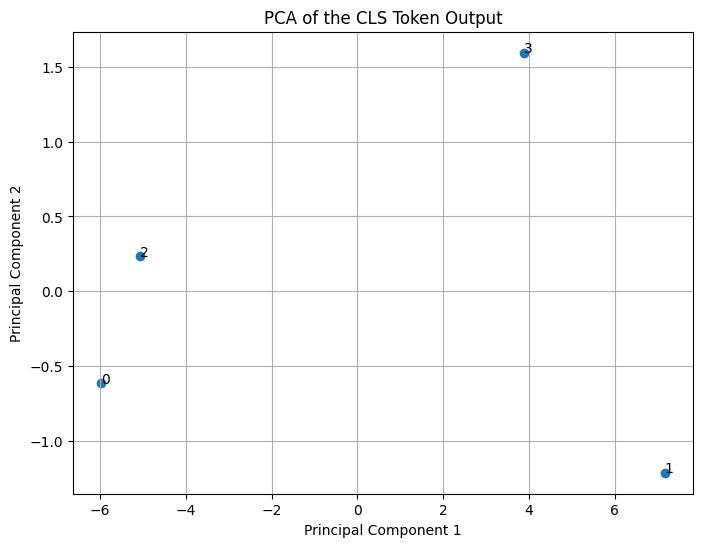

In [88]:
plt.figure(figsize=(8, 6))  # Set the figure size for the plot
scatter = plt.scatter(X_pca.loc[:, 0], X_pca.loc[:, 1])  # Plot the two PCA components (first and second principal component)

# Annotate each point in the scatter plot
for i in range(X_pca.shape[0]):
    cur_record = X_pca.iloc[i,:].copy()
    plt.annotate(cur_record.name, (cur_record[0], cur_record[1]))  # Annotate each point with its index

# Label the axes
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Title for the plot
plt.title('PCA of the CLS Token Output')

# Display a grid for better readability
plt.grid(True)

# Show the plot
plt.show()


**Checking Predictions:** After visualizing the CLS token output, it’s useful to check the corresponding predictions to understand whether the model’s representation (as seen in the PCA plot) aligns with the predictions. For example, sentences with similar sentiments should cluster together in the PCA plot.

In [89]:
# Print the sentiment predictions for the custom sentences
print(predictions)


tensor([1, 0, 1, 0], device='cuda:0')


## 4B2: Inspecting Layer Weights in the Trained Model

In this section, we aim to inspect and understand the internal weights of a trained transformer model. Accessing the model's weights is crucial for debugging, understanding how the model is learning, and potentially making custom adjustments.

**Accessing the Model’s state_dict**:

- The state_dict is a dictionary-like object that stores all the parameters of the model, such as weights and biases, indexed by their corresponding layer names. Each key in this dictionary represents a specific layer, and the associated value holds the weights or biases for that layer.

- Purpose: By printing the keys (layer names) and the corresponding parameter sizes, you get a complete overview of the model’s architecture. This allows you to see how the layers are structured and how much information each layer is responsible for processing. It's especially useful for understanding the internal structure of the model and verifying that the model layers are set up correctly.

- Why This Is Important: Inspecting the internal weights and biases of your model is essential for understanding how the model is learning and processing data. Each layer's weight matrix plays a crucial role in transforming the input data as it moves through the model. By checking these weights, you ensure that the model is learning as expected, which is critical for debugging, analyzing, and fine-tuning the model’s performance.

- This process helps ensure that the model is functioning as intended and provides insights into how the model adapts to the input data during training.

In [90]:
# Assuming model is your trained PyTorch model
# The 'state_dict' contains all the weights and biases of the model layers

state_dict = model.state_dict()

# Print all keys in the state_dict to see available weights
for name, param in state_dict.items():
    print(f"Layer: {name}, Size: {param.size()}")


Layer: embedding.weight, Size: torch.Size([28996, 64])
Layer: pos_encoding.pe, Size: torch.Size([1, 512, 64])
Layer: transformer_blocks.0.ln1.weight, Size: torch.Size([64])
Layer: transformer_blocks.0.ln1.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.ln2.weight, Size: torch.Size([64])
Layer: transformer_blocks.0.ln2.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.mha.key.weight, Size: torch.Size([64, 64])
Layer: transformer_blocks.0.mha.key.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.mha.query.weight, Size: torch.Size([64, 64])
Layer: transformer_blocks.0.mha.query.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.mha.value.weight, Size: torch.Size([64, 64])
Layer: transformer_blocks.0.mha.value.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.mha.fc.weight, Size: torch.Size([64, 64])
Layer: transformer_blocks.0.mha.fc.bias, Size: torch.Size([64])
Layer: transformer_blocks.0.ann.0.weight, Size: torch.Size([256, 64])
Layer: transformer_blo

**Accessing Weights of a Specific Layer:**
- Explanation:
  - Layer name: In this example, we are looking at the query weight matrix in the first transformer block's multi-head attention layer (mha.query.weight). The name of this layer is based on how it is structured in the model.
      - transformer_blocks.0 refers to the first block of the transformer.
      - mha.query.weight is the query weight matrix in the multi-head attention mechanism.
  - Accessing the layer weights: Using the state_dict dictionary, we can extract the specific weights of this layer.
  - Print the weights and dimensions: We print the values of the weights as well as their shape to inspect what the model has learned for that layer.

- Why this is important:
  - Debugging and analysis: By accessing a specific layer’s weights, you can inspect what the model has learned. For instance, in multi-head attention, the query weight matrix determines how the model focuses on different parts of the input sequence.
  - Model interpretation: Understanding the shape and values of the weights helps you verify that the model is learning as expected and can provide insights into how the attention mechanism works internally.

In [91]:
# Example: Accessing weights of a specific layer in the transformer model
# In this case, we're interested in the query weights of the first multi-head attention layer
layer_name = 'transformer_blocks.0.mha.query.weight'  # Specify the layer you want to access

# Extract the weights of this specific layer
layer_weights = state_dict[layer_name]

# Print the weights of the selected layer and their dimensions
print(f"Weights of {layer_name}:")
print(layer_weights)
print(f'Dim: {layer_weights.shape}')


Weights of transformer_blocks.0.mha.query.weight:
tensor([[ 0.0510, -0.1041, -0.0073,  ..., -0.0436,  0.0890,  0.0708],
        [ 0.0112, -0.0871,  0.1724,  ..., -0.0378,  0.0939, -0.0058],
        [-0.0405, -0.1127,  0.0513,  ...,  0.1051,  0.1368,  0.0834],
        ...,
        [ 0.1396, -0.1692,  0.0787,  ...,  0.0174,  0.2469, -0.1899],
        [ 0.0023, -0.0962,  0.0565,  ..., -0.0893,  0.0796,  0.0590],
        [-0.1533, -0.0740, -0.0544,  ..., -0.0726,  0.0167, -0.1418]],
       device='cuda:0')
Dim: torch.Size([64, 64])


## 4B3: Inspecting the Embeddings Layer

In this section, we are focusing on inspecting the embedding layer of the model. The embedding layer is responsible for converting input tokens (words or subwords) into continuous vector representations that can be processed by the transformer model. These embeddings are a crucial part of how the model interprets and learns relationships between words.

**Accessing the Embedding Layer Weights**:

- Explanation:
  - Embedding Layer: The embedding.weight is the set of embeddings that maps each word (or token) from the vocabulary into a continuous vector space.
  - Accessing weights: By specifying embedding.weight as the layer name, we extract the learned word vectors for the entire vocabulary from the model’s state_dict.
  - Print the weights and dimensions: After extracting the embeddings, we print them to inspect how the model has learned to represent words. The dimension of the weights will indicate how large the vocabulary is (number of tokens) and the size of the vector used to represent each word (embedding dimension).
- Why this is important:
The embedding layer is critical because it transforms discrete word tokens into continuous vector representations that the model can process. By inspecting these embeddings, we can verify whether the model has learned meaningful word representations. Each word or token is mapped to a unique embedding vector that encodes semantic relationships between words.

In [92]:
# Specify the layer name for the embedding weights
layer_name = 'embedding.weight'  # This points to the embedding layer of the model

# Extract the weights of the embedding layer from the model's state dictionary
layer_weights = state_dict[layer_name]

# Print the weights of the embedding layer and their dimensions
print(f"Weights of {layer_name}:")
print(layer_weights)
print(f'Dim: {layer_weights.shape}')


Weights of embedding.weight:
tensor([[ 0.4125,  1.2084,  1.0752,  ...,  0.4836, -0.1298, -0.6972],
        [ 0.3495, -1.2032,  0.7195,  ..., -0.1309, -0.3047, -0.6155],
        [ 0.6616, -1.4361,  1.0968,  ..., -0.8420, -0.6925,  0.5882],
        ...,
        [-1.9613,  0.7972,  0.1082,  ..., -0.6414,  2.0235,  0.0399],
        [ 0.1950, -1.2179, -2.1154,  ..., -0.7434,  1.6861,  0.0533],
        [-1.6200,  2.3770,  1.1757,  ...,  0.9657, -0.7855, -0.5664]],
       device='cuda:0')
Dim: torch.Size([28996, 64])


**Vocabulary Size and Tokenization**

- Explanation:
  - Vocabulary Size: len(tokenizer.vocab.keys()) gives the total number of unique tokens (words or subwords) that the tokenizer uses. This should match the size of the embedding layer’s first dimension (number of rows in the weight matrix).
  - Inspecting the Vocabulary: tokenizer.vocab returns the full mapping of token strings to their corresponding token IDs. This allows us to understand which words or subwords are being represented in the embedding layer.
- Why this is important:
  - Consistency Check: Checking the vocabulary size helps ensure that the embedding layer correctly matches the tokenizer's vocabulary. The number of embeddings should be equal to the number of unique tokens in the vocabulary.
  - Vocabulary Analysis: By inspecting the vocabulary, you gain insight into how the text is tokenized and how the words or subwords are represented in the model. This helps you understand how the model interprets the input text before converting it into embeddings.


In [93]:
# Check the size of the vocabulary used by the tokenizer
len(tokenizer.vocab.keys())

# Inspect the tokenizer's vocabulary
tokenizer.vocab


{'rebuilt': 6669,
 '2011': 1349,
 '##MO': 20647,
 '⟨': 882,
 'moaning': 26944,
 'N': 151,
 '##eman': 12437,
 '##●': 28766,
 '##LP': 20009,
 '##emption': 19007,
 'prison': 3315,
 'display': 3934,
 '##ryn': 15023,
 '##ych': 21155,
 '##ilizer': 25833,
 '##ismic': 24864,
 '##ivist': 23936,
 'density': 3476,
 'vacation': 12020,
 'Miller': 3902,
 'assessing': 23529,
 'Guitar': 7656,
 '##word': 12565,
 'probation': 23793,
 'れ': 929,
 '##glass': 16802,
 'Hits': 12852,
 '##berry': 6614,
 '##hs': 9524,
 '[unused55]': 55,
 '##uveau': 27377,
 'noteworthy': 22076,
 'MW': 13277,
 'racism': 16654,
 'Brandon': 8464,
 'jolt': 26078,
 '1795': 13731,
 'Muir': 25952,
 'Davies': 8746,
 'pig': 13407,
 'naturalist': 23439,
 'spectacular': 14449,
 '##ogue': 18597,
 'economically': 16682,
 'Honour': 16451,
 'papers': 4580,
 'torment': 25944,
 'rendering': 15171,
 'Advisory': 9433,
 'Girl': 4537,
 'relates': 15286,
 '##egan': 18886,
 'delayed': 8088,
 'ribbon': 14253,
 'missionary': 10263,
 'startling': 22425,


## 4B4: Creating a Word Cloud and Visualizing Word Embeddings

This section focuses on visualizing the learned word embeddings using PCA (Principal Component Analysis) and creating a word cloud to find important words in the dataset.



**Applying PCA to Word Embeddings**

- We convert the embedding layer weights to a NumPy array and scale them using StandardScaler to standardize the data.
- PCA is applied to reduce the word embeddings to 2D, making them easier to visualize.

In [94]:
# Convert the embedding weights (layer_weights) to a NumPy array and move to CPU
embeddings_output = layer_weights.to('cpu').numpy()

# Scale the embeddings for better PCA performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings_output)

# Apply PCA to reduce embeddings to 2 dimensions for easier visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert the PCA results to a DataFrame, indexed by the tokenizer's vocabulary
X_pca = pd.DataFrame(X_pca, index=tokenizer.vocab.keys())


**Creating the Word Cloud:**
- We generate a word cloud from the training dataset to visualize the most common words. This provides an overview of the important tokens in the dataset based on their frequency.

In [95]:
train_ids = tokenized_datasets['train']['input_ids']


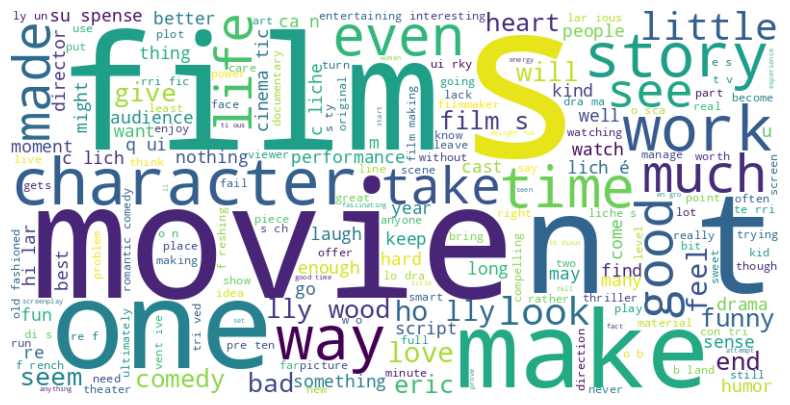

In [96]:
# Combine all the tokens from the training data to create input for the word cloud

# Filter out special tokens like [CLS], [SEP], [PAD], and [UNK]
special_tokens = set([tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token, tokenizer.unk_token])

combined_text = ' '.join(
    ' '.join([token for token in tokenizer.convert_ids_to_tokens(train_ids[i]) if token not in special_tokens])
    for i in range(len(train_ids))
)

# Generate the word cloud from the combined text
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(combined_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes for a cleaner look
plt.show()


**Plotting the PCA for Selected Words:**
- We shortlist specific words (like "humor", "comedy", and "funny") and plot their positions in the reduced PCA space. This helps visualize how these related words are represented in the embedding space.
- The scatter plot shows how close or far apart these words are, which reflects the relationships the model has learned between them.

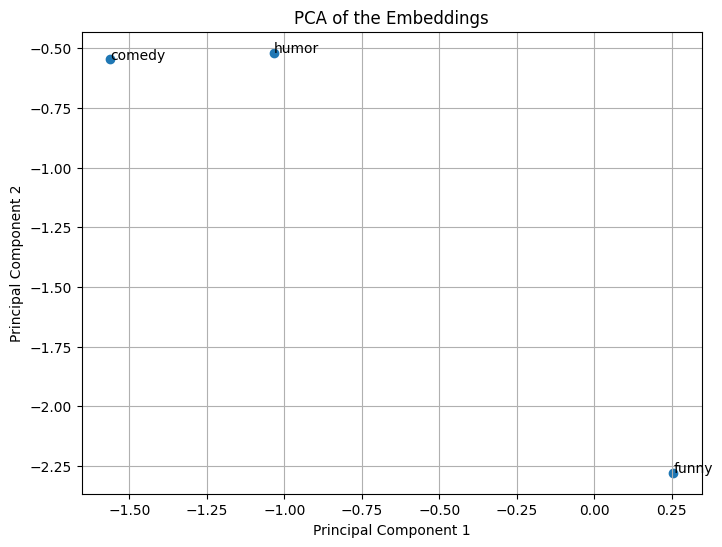

In [97]:
# Shortlist specific words to plot in PCA (e.g., 'humor', 'comedy', 'funny')
# Filter out words not in the vocabulary
req_words = [word for word in ['humor', 'comedy', 'funny'] if word in tokenizer.vocab]
pca_req_words = X_pca.loc[req_words, :].copy()

# Plot the PCA results for the selected words
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_req_words.loc[:, 0], pca_req_words.loc[:, 1])

# Annotate the words on the plot
for i in range(pca_req_words.shape[0]):
    cur_record = pca_req_words.iloc[i, :].copy()
    plt.annotate(cur_record.name, (cur_record[0], cur_record[1]))

# Label the axes and add a title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the Embeddings')
plt.grid(True)
plt.show()
